# Fantacalcio Project!

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

## 1 - Load and Preprocess Data

In [3]:
df_raw = pd.read_excel(r"Calendario_SUPERleGA.xlsx",  skiprows=2)
df_raw.columns = list(range(0,11))
df_raw.head(10)


,0,1,2,3,4,5,6,7,8,9,10
0,1ª Giornata lega,NaN,5ª Giornata serie a,NaN,NaN,NaN,2ª Giornata lega,NaN,6ª Giornata serie a,NaN,NaN
1,I Tortellini di Barbieri,62.0,64.5,Berlusca Dortmund,0-0,NaN,Berlusca Dortmund,73.5,67,Amaro Luciano,2-1
2,toTorina,72.0,67.5,Herta Vernello,2-1,NaN,Gerry storti,75.5,69,Regina Celik,2-1
3,Regina Celik,77.5,76,SS Totenkopfverbande,3-3,NaN,SS Totenkopfverbande,77.0,76,toTorina,3-3
4,Amaro Luciano,67.0,68.5,Gerry storti,1-1,NaN,Herta Vernello,81.5,76,I Tortellini di Barbieri,4-3
5,3ª Giornata lega,NaN,7ª Giornata serie a,NaN,NaN,NaN,4ª Giornata lega,NaN,8ª Giornata serie a,NaN,NaN
6,toTorina,75.0,60.5,Gerry storti,2-0,NaN,I Tortellini di Barbieri,71.5,67,Regina Celik,2-1
7,Regina Celik,79.0,63.5,Berlusca Dortmund,3-0,NaN,Berlusca Dortmund,60.5,70.5,toTorina,0-1
8,Amaro Luciano,62.0,74.5,I Tortellini di Barbieri,0-2,NaN,Gerry storti,68.5,78,SS Totenkopfverbande,1-3
9,SS Totenkopfverbande,66.0,77,Herta Vernello,1-3,NaN,Herta Vernello,71.0,69.5,Amaro Luciano,2-1


Let's put the data into a suitable format

In [4]:
def process_matchdays(df, cols):

    # pick columns for even or odd matchdays
    df_sub = df[cols].copy() 

    df_sub.columns = ['0', '1', '2', '3']

    # identify rows containing matchday headers in column '0'
    df_sub['Matchday'] = df_sub['0'].where(df_sub['0'].str.contains('Giornata', na=False))

    # forward fill the Matchday column
    df_sub['Matchday'] = df_sub['Matchday'].ffill()

    # extract numeric matchday number
    df_sub['Matchday'] = df_sub['Matchday'].str.extract(r'(\d+)').astype(int)

    # drop rows where any cell contains 'Giornata' s.t. we only keep the match data
    df_sub = df_sub[~df_sub.apply(lambda row: row.astype(str).str.contains('Giornata').any(), axis=1)].reset_index(drop=True)

    return df_sub


In [ ]:
odd_matchdays = process_matchdays(df_raw, [0,1,2,3])
even_matchdays = process_matchdays(df_raw, [6,7,8,9])

all_matchdays = pd.concat([odd_matchdays, even_matchdays], ignore_index=True)
all_matchdays = all_matchdays.sort_values(by='Matchday').reset_index(drop=True)

# rename columns
all_matchdays.columns = ['Home', 'Home_Points', 'Away_Points', 'Away', 'Matchday']

all_matchdays.head(5)


,Home,Home_Points,Away_Points,Away,Matchday
0,I Tortellini di Barbieri,62.0,64.5,Berlusca Dortmund,1
1,toTorina,72.0,67.5,Herta Vernello,1
2,Regina Celik,77.5,76,SS Totenkopfverbande,1
3,Amaro Luciano,67.0,68.5,Gerry storti,1
4,Berlusca Dortmund,73.5,67,Amaro Luciano,2


We will now remove matchdays where both "Home_Points" and "Away_Points" are zero. That's because if they are all zeros then probably the match has not been played yet.

In [8]:
initial_shape = all_matchdays.shape

zero_points_matchdays = all_matchdays.groupby('Matchday').filter(
    lambda g: (g['Home_Points'] == 0).all() and (g['Away_Points'] == 0).all()
)

# Get unique matchdays where this condition holds
matchdays_with_all_zeros = zero_points_matchdays['Matchday'].unique()

all_matchdays = all_matchdays[~all_matchdays['Matchday'].isin(matchdays_with_all_zeros)]

print(f"Removed {initial_shape[0] - all_matchdays.shape[0]} rows with all zero points in matchdays: {matchdays_with_all_zeros}")


Removed 0 rows with all zero points in matchdays: []


We build the scoreboard just to check if it matches with the one in the app

In [11]:
df_results=all_matchdays.copy()

# Create a list of all teams (from both Home and Away columns)
teams = pd.unique(df_results[['Home', 'Away']].values.ravel())

rows = []

for team in teams:
    # Home games stats
    home_games = df_results[df_results['Home'] == team]
    home_GF = home_games['Home_Points'].sum()
    home_GA = home_games['Away_Points'].sum()
    home_MP = len(home_games)
    
    # Away games stats
    away_games = df_results[df_results['Away'] == team]
    away_GF = away_games['Away_Points'].sum()
    away_MP = len(away_games)
    
    # Totals
    MP = home_MP + away_MP
    GF = home_GF + away_GF
    
    rows.append({
        'Team': team,
        'MP': MP,
        'GF': GF
    })

classifica = pd.DataFrame(rows)

classifica = classifica.sort_values(by=['GF'], ascending=False).reset_index(drop=True)

print(classifica)


                       Team  MP      GF
0                  toTorina  33  2386.5
1              Regina Celik  33  2371.0
2      SS Totenkopfverbande  33  2354.5
3         Berlusca Dortmund  33  2336.0
4              Gerry storti  33  2324.5
5             Amaro Luciano  33  2301.0
6            Herta Vernello  33  2270.5
7  I Tortellini di Barbieri  33  2246.5


In [ ]:
df=all_matchdays.copy()
df.shape


(132, 5)

In [ ]:
min_thrs = 66
points_per_goals = 5

def points_to_goals(points, min_thrs=66, points_per_goals=5):
    if points < min_thrs:
        return 0
    return (points - min_thrs) // points_per_goals + 1

df['Home_Goals'] = df['Home_Points'].apply(points_to_goals)
df['Away_Goals'] = df['Away_Points'].apply(points_to_goals)

def compute_points(row):
    if row['Home_Goals'] > row['Away_Goals']:
        return 3, 0
    elif row['Home_Goals'] < row['Away_Goals']:
        return 0, 3
    else:
        return pd.Series([1, 1])

df[["WDL_Home", "WDL_Away"]] = df.apply(compute_points, axis=1)
df.head(20)


,Home,Home_Points,Away_Points,Away,Matchday,Home_Goals,Away_Goals,WDL_Home,WDL_Away
0,I Tortellini di Barbieri,62.0,64.5,Berlusca Dortmund,1,0.0,0.0,1,1
1,toTorina,72.0,67.5,Herta Vernello,1,2.0,1.0,3,0
2,Regina Celik,77.5,76,SS Totenkopfverbande,1,3.0,3.0,1,1
3,Amaro Luciano,67.0,68.5,Gerry storti,1,1.0,1.0,1,1
4,Berlusca Dortmund,73.5,67,Amaro Luciano,2,2.0,1.0,3,0
5,Gerry storti,75.5,69,Regina Celik,2,2.0,1.0,3,0
6,SS Totenkopfverbande,77.0,76,toTorina,2,3.0,3.0,1,1
7,Herta Vernello,81.5,76,I Tortellini di Barbieri,2,4.0,3.0,3,0
8,toTorina,75.0,60.5,Gerry storti,3,2.0,0.0,3,0
9,Regina Celik,79.0,63.5,Berlusca Dortmund,3,3.0,0.0,3,0


## 2 - Average Home and Away Points per Club

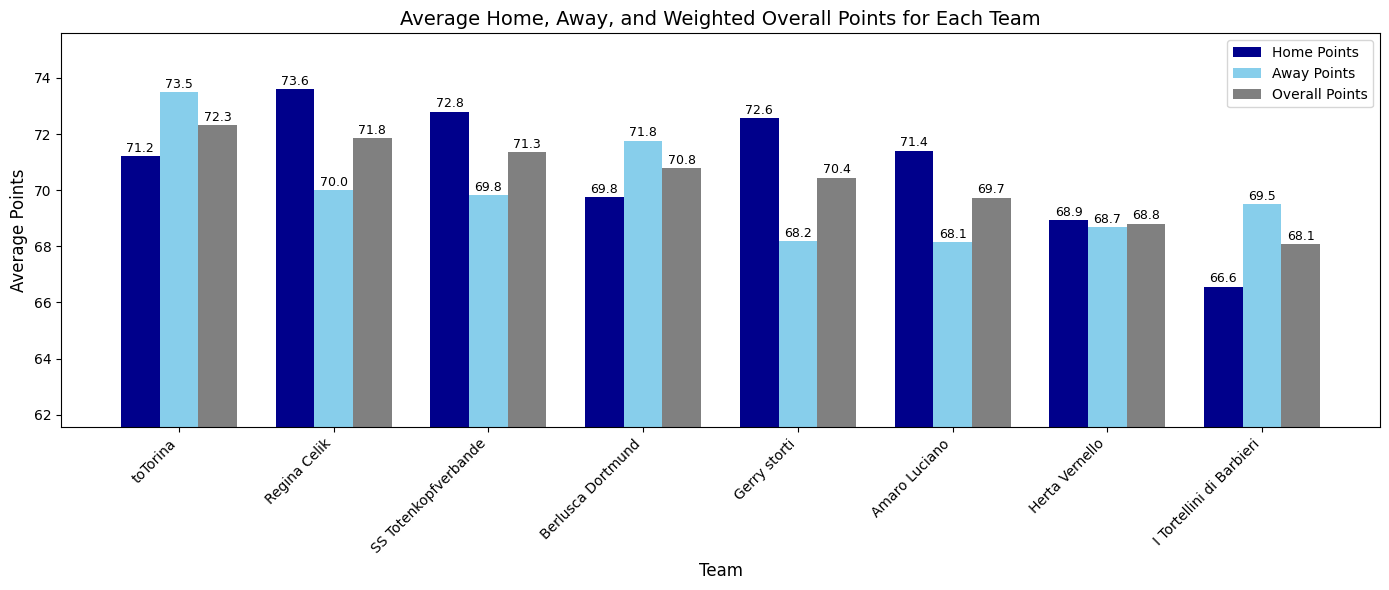

In [35]:
def plot_team_points(df):
    # Compute total points and match counts for home and away
    home_stats = df.groupby("Home")["Home_Points"].agg(["sum", "count"]).rename(columns={"sum": "Home_Total", "count": "Home_Matches"})
    away_stats = df.groupby("Away")["Away_Points"].agg(["sum", "count"]).rename(columns={"sum": "Away_Total", "count": "Away_Matches"})

    # Merge into one DataFrame
    points_df = home_stats.join(away_stats)

    # Compute averages
    points_df["Home Points"] = points_df["Home_Total"] / points_df["Home_Matches"]
    points_df["Away Points"] = points_df["Away_Total"] / points_df["Away_Matches"]

    # Weighted Overall Points
    points_df["Overall Points"] = (
        (points_df["Home_Total"] + points_df["Away_Total"]) /
        (points_df["Home_Matches"] + points_df["Away_Matches"])
    )

    # Sort by Overall Points
    points_df = points_df.sort_values(by="Overall Points", ascending=False)

    # Plotting
    x = np.arange(len(points_df))
    width = 0.25
    fig, ax = plt.subplots(figsize=(14, 6))

    # Bars
    bars1 = ax.bar(x - width, points_df['Home Points'], width, label='Home Points', color='darkblue')
    bars2 = ax.bar(x, points_df['Away Points'], width, label='Away Points', color='skyblue')
    bars3 = ax.bar(x + width, points_df['Overall Points'], width, label='Overall Points', color='gray')

    # Y-axis limits
    all_scores = np.concatenate([
        points_df['Home Points'].values,
        points_df['Away Points'].values,
        points_df['Overall Points'].values
    ])
    ax.set_ylim((all_scores.min() - 5, all_scores.max() + 2))

    # Annotate bars
    for bars in [bars1, bars2, bars3]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2, height + 0.05, f'{height:.1f}', ha='center', va='bottom', fontsize=9)

    # Axes and labels
    ax.set_title("Average Home, Away, and Weighted Overall Points for Each Team", fontsize=14)
    ax.set_xlabel("Team", fontsize=12)
    ax.set_ylabel("Average Points", fontsize=12)
    ax.set_xticks(x)
    ax.set_xticklabels(points_df.index, rotation=45, ha='right')
    ax.legend()
    ax.grid(False)

    plt.tight_layout()
    plt.show()


plot_team_points(df)


## 3 - Points Time Series per Club

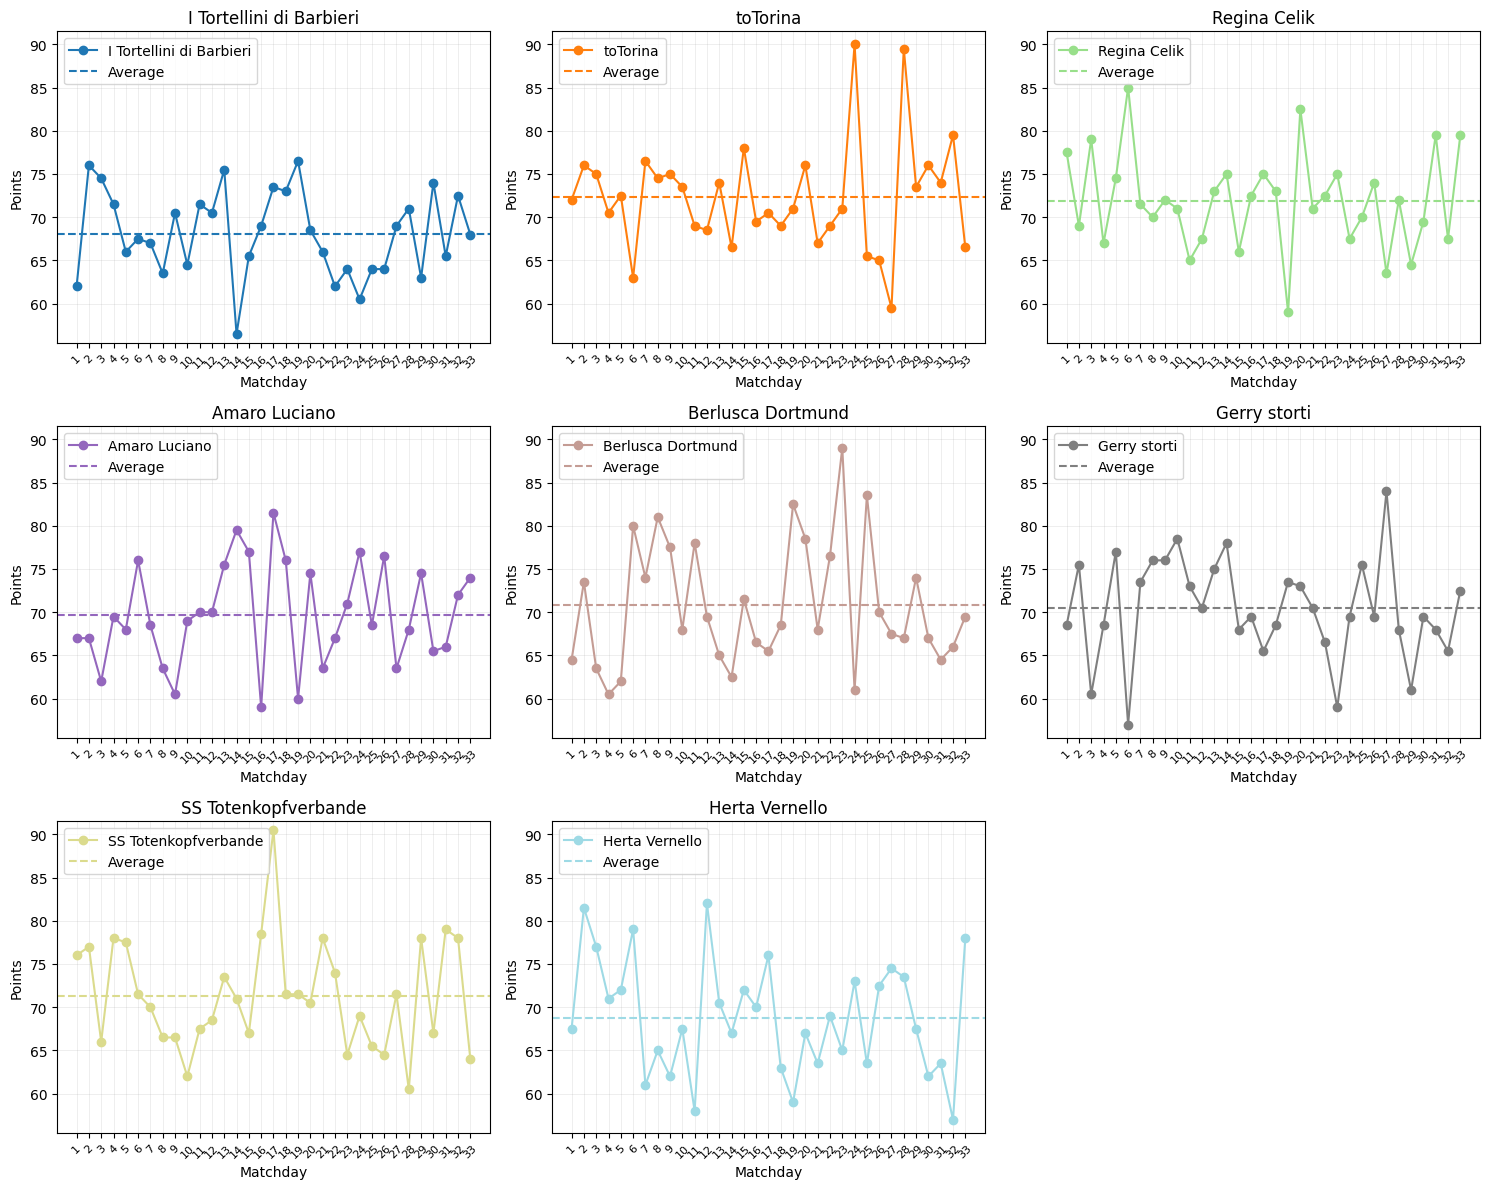

In [40]:
def plot_club_time_series(df):
    club_names = df['Home'].unique()

    # Calcola i limiti dinamici dell'asse y
    y_lim_min = min(df['Home_Points'].min(), df['Away_Points'].min()) - 1
    y_lim_max = max(df['Home_Points'].max(), df['Away_Points'].max()) + 1

    # Crea dizionario time series
    time_series = {club: [] for club in club_names}
    for _, row in df.iterrows():
        time_series[row["Home"].strip()].append((row["Matchday"], row["Home_Points"]))
        time_series[row["Away"].strip()].append((row["Matchday"], row["Away_Points"]))

    # Converti in DataFrame per il plotting
    time_series_df = pd.DataFrame(columns=["Matchday"] + list(time_series.keys()))
    for club, scores in time_series.items():
        df_club = pd.DataFrame(scores, columns=["Matchday", club])
        if time_series_df.empty:
            time_series_df = df_club
        else:
            time_series_df = time_series_df.merge(df_club, on="Matchday", how="outer")

    time_series_df.set_index("Matchday", inplace=True)
    time_series_df.sort_index(inplace=True)

    # Calcola la media totale per ciascuna squadra (ignora NaN)
    overall_means = time_series_df.mean(axis=0)

    # Numero di subplot
    num_clubs = len(time_series)
    ncols = 3
    nrows = (num_clubs // ncols) + (num_clubs % ncols > 0)

    # Crea subplot
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows * 4))
    axes = axes.flatten()

    # Colormap
    colors = plt.colormaps.get_cmap('tab20').resampled(num_clubs)

    # Plot per ogni club con linea media orizzontale tratteggiata
    for i, club in enumerate(time_series.keys()):
        club_color = colors(i)
        axes[i].plot(time_series_df.index, time_series_df[club], marker="o", label=club, color=club_color)
        # Linea orizzontale tratteggiata con media totale per la squadra, stessa tonalità
        axes[i].axhline(y=overall_means[club], color=club_color, linestyle='--', label='Average')
        axes[i].set_title(club)
        axes[i].set_xlabel("Matchday")
        axes[i].set_ylabel("Points")
        axes[i].set_ylim(y_lim_min, y_lim_max)
        axes[i].grid(True, linewidth=0.5, alpha=0.3)
        axes[i].legend(loc="upper left")

        # Migliora leggibilità asse x
        axes[i].set_xticks(time_series_df.index)
        axes[i].tick_params(axis='x', rotation=45, labelsize=8)

    # Rimuovi subplot vuoti
    for j in range(num_clubs, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()


plot_club_time_series(df)


## 4 - Win and Lose Streak

In [41]:
# Prepare long-format match data
club_data = []
for _, row in df.iterrows():
    club_data.append({"Club": row["Home"], "Points": row["Home_Points"], "Home_or_Away": "Home", "Goals": row["Home_Goals"], "WDL": row["WDL_Home"], "Matchday": row["Matchday"]})
    club_data.append({"Club": row["Away"], "Points": row["Away_Points"], "Home_or_Away": "Away", "Goals": row["Away_Goals"], "WDL": row["WDL_Away"], "Matchday": row["Matchday"]})

club_df = pd.DataFrame(club_data)

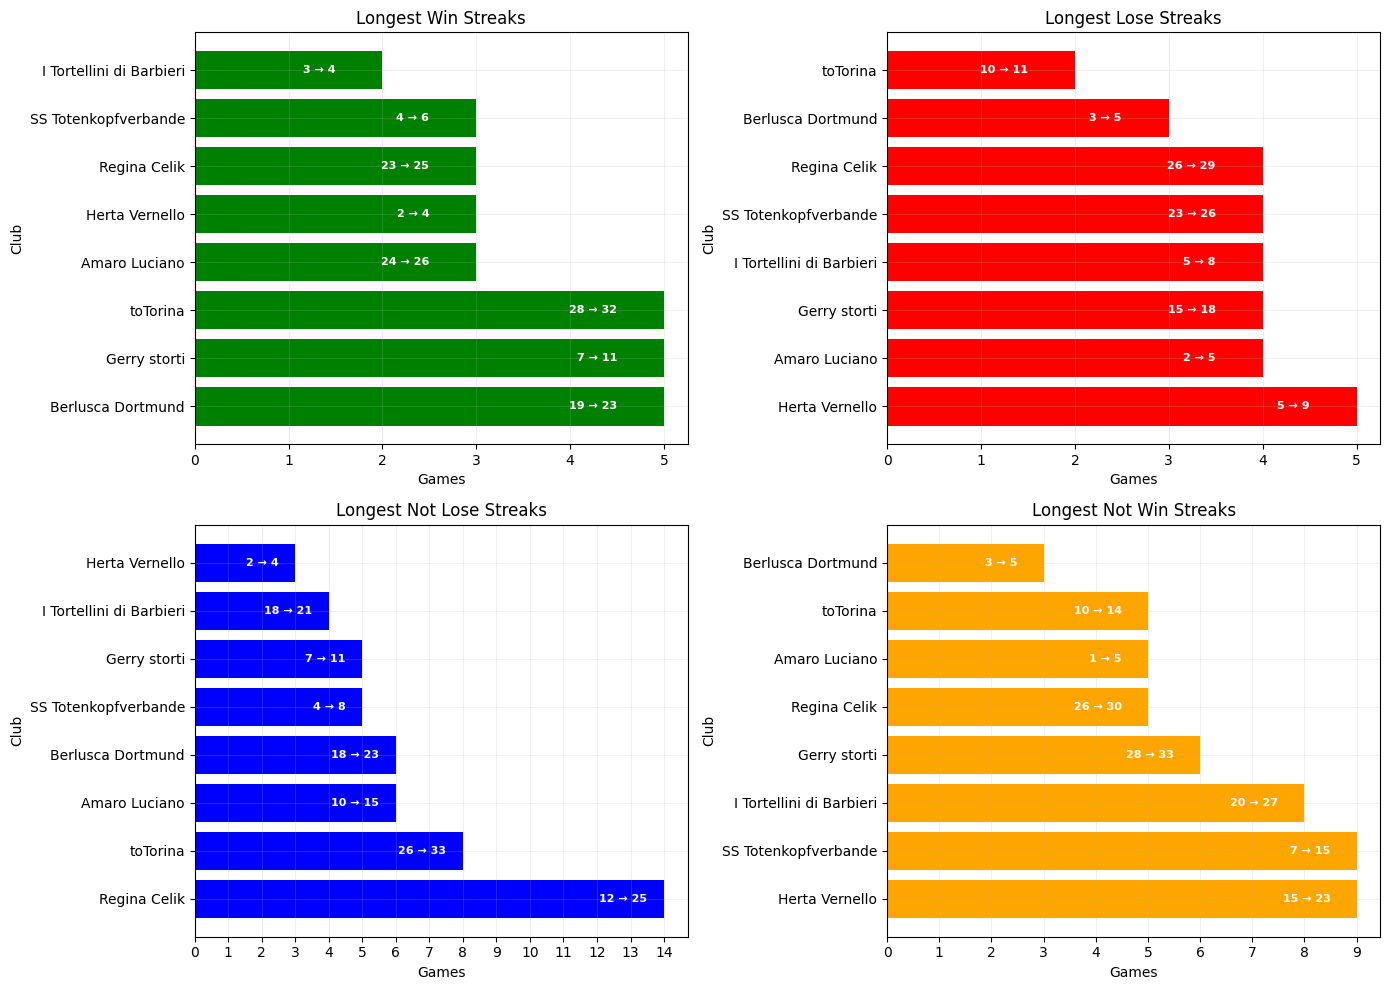

In [ ]:
def plot_longest_streaks(club_df):
    # Store streak values and their matchday ranges
    streaks = {
        "win": {}, "lose": {}, "not_lose": {}, "not_win": {}
    }
    ranges = {
        "win": {}, "lose": {}, "not_lose": {}, "not_win": {}
    }

    for team, data in club_df.groupby("Club"):
        data = data.sort_values(by="Matchday")  # Ensure chronological order

        # Initialize streak tracking
        win = lose = not_lose = not_win = 0
        win_start = lose_start = not_lose_start = not_win_start = None
        max_win = max_lose = max_not_lose = max_not_win = 0
        max_win_range = max_lose_range = max_not_lose_range = max_not_win_range = ("", "")

        for idx, row in data.iterrows():
            day = row["Matchday"]

            # Win streak
            if row["WDL"] == 3:
                if win == 0: win_start = day
                win += 1
                if win > max_win:
                    max_win = win
                    max_win_range = (win_start, day)
                lose = 0
                not_win = 0
                if not_lose == 0: not_lose_start = day
                not_lose += 1
                if not_lose > max_not_lose:
                    max_not_lose = not_lose
                    max_not_lose_range = (not_lose_start, day)
            # Loss streak
            elif row["WDL"] == 0:
                if lose == 0: lose_start = day
                lose += 1
                if lose > max_lose:
                    max_lose = lose
                    max_lose_range = (lose_start, day)
                win = 0
                not_lose = 0
                if not_win == 0: not_win_start = day
                not_win += 1
                if not_win > max_not_win:
                    max_not_win = not_win
                    max_not_win_range = (not_win_start, day)
            # Draw
            else:
                win = lose = 0
                if not_lose == 0: not_lose_start = day
                not_lose += 1
                if not_lose > max_not_lose:
                    max_not_lose = not_lose
                    max_not_lose_range = (not_lose_start, day)
                if not_win == 0: not_win_start = day
                not_win += 1
                if not_win > max_not_win:
                    max_not_win = not_win
                    max_not_win_range = (not_win_start, day)

        # Save results
        for key, max_val, rng in zip(
            ["win", "lose", "not_lose", "not_win"],
            [max_win, max_lose, max_not_lose, max_not_win],
            [max_win_range, max_lose_range, max_not_lose_range, max_not_win_range]
        ):
            streaks[key][team] = max_val
            ranges[key][team] = rng

    # Convert to sorted DataFrames with ranges
    dfs = {}
    for key in ["win", "lose", "not_lose", "not_win"]:
        df_temp = pd.DataFrame([
            {"Club": club, "Streak": streaks[key][club], "Range": f"{ranges[key][club][0]} → {ranges[key][club][1]}"}
            for club in streaks[key]
        ])
        dfs[key] = df_temp.sort_values(by="Streak", ascending=False)

    titles = {
        "win": "Longest Win Streaks",
        "lose": "Longest Lose Streaks",
        "not_lose": "Longest Not Lose Streaks",
        "not_win": "Longest Not Win Streaks"
    }

    colors = {
        "win": "green",
        "lose": "red",
        "not_lose": "blue",
        "not_win": "orange"
    }

    # Plotting
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()

    for i, key in enumerate(["win", "lose", "not_lose", "not_win"]):
        df_plot = dfs[key]
        bars = axes[i].barh(df_plot["Club"], df_plot["Streak"], color=colors[key])
        axes[i].set_title(titles[key])
        axes[i].set_xlabel("Games")
        axes[i].set_ylabel("Club")
        axes[i].set_xticks(range(0, int(df_plot["Streak"].max()) + 1))
        axes[i].grid(True, linewidth=0.5, alpha=0.3)

        # Annotate bars with the Matchday range
        for bar, label in zip(bars, df_plot["Range"]):
            width = bar.get_width()
            if width > 0:
                axes[i].text(width - 0.5, bar.get_y() + bar.get_height()/2,
                             label, va='center', ha='right', color='white', fontsize=8, fontweight='bold')

    plt.tight_layout()
    plt.show()

plot_longest_streaks(club_df)


## 5 - Goals 

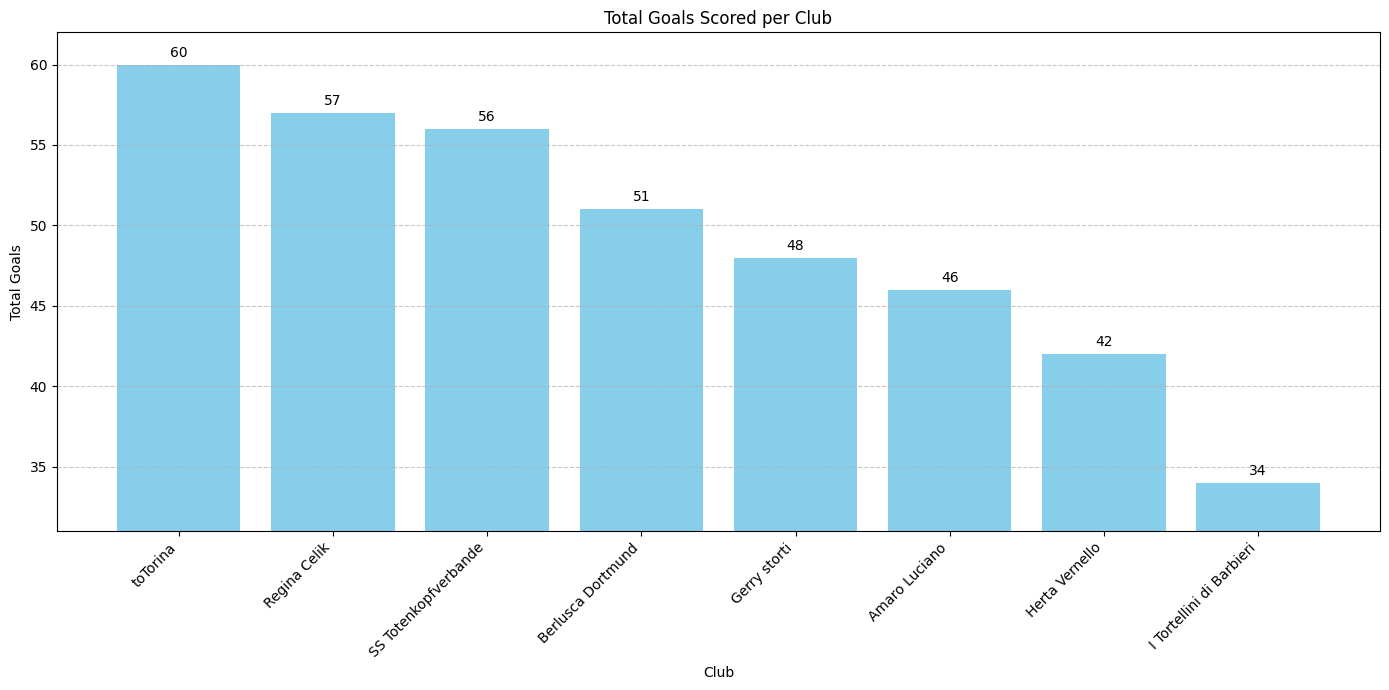

In [ ]:
def plot_goals_per_club(club_df):
    # Sum goals by club
    goals_per_club = club_df.groupby("Club")["Goals"].sum().sort_values(ascending=False)
    
    # Calculate y-axis limits
    y_min = max(0, goals_per_club.min() - 3)  # don't go below 0
    y_max = goals_per_club.max() + 2
    
    # Plot vertical bar chart
    plt.figure(figsize=(14, 7))
    bars = plt.bar(goals_per_club.index, goals_per_club.values, color='skyblue')
    plt.ylabel('Total Goals')
    plt.xlabel('Club')
    plt.title('Total Goals Scored per Club')
    plt.ylim(y_min, y_max)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.xticks(rotation=45, ha='right')

    # Add numbers above bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + 0.3, f'{int(height)}', 
                 ha='center', va='bottom', fontsize=10)

    plt.tight_layout()
    plt.show()

plot_goals_per_club(club_df)


## 6 - Points Per Goal

In [51]:
total_points = club_df.groupby("Club")["Points"].sum()
total_goals = club_df.groupby("Club")["Goals"].sum()
total_wdl = club_df.groupby("Club")["WDL"].sum()

score_board = pd.merge(total_points, total_goals, on="Club")
score_board = pd.merge(score_board, total_wdl, on="Club")

score_board = score_board.sort_values(by="WDL", ascending=False)

score_board.head(20)


,Points,Goals,WDL
Club,,,
toTorina,2386.5,60.0,59
Berlusca Dortmund,2336.0,51.0,57
Regina Celik,2371.0,57.0,53
Amaro Luciano,2301.0,46.0,49
SS Totenkopfverbande,2354.5,56.0,42
Gerry storti,2324.5,48.0,40
Herta Vernello,2270.5,42.0,36
I Tortellini di Barbieri,2246.5,34.0,34


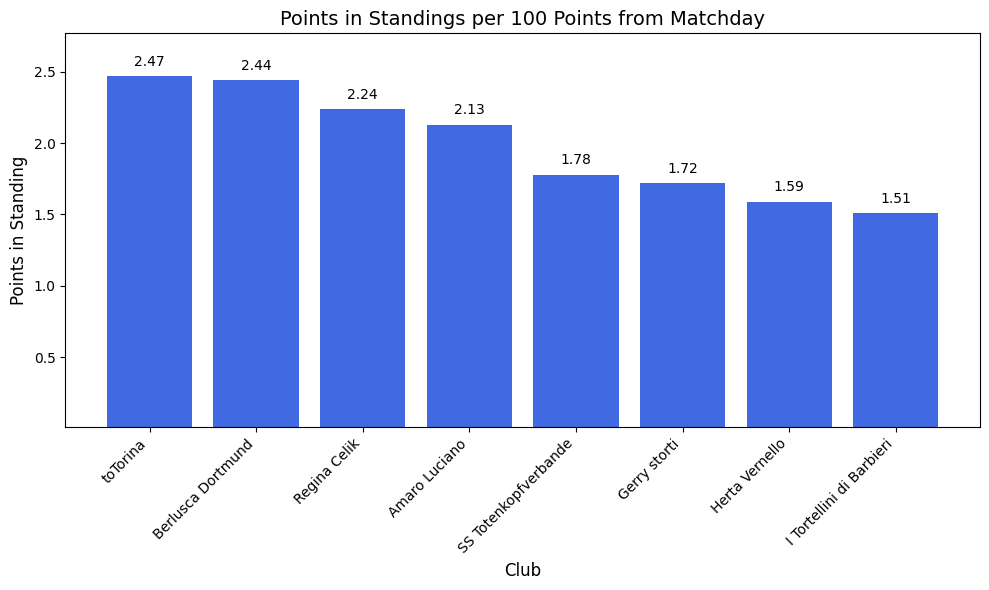

In [149]:
def points_stending_per_points(score_board):
    # Compute the percentage and sort
    wdl_percentage = round(100 * score_board["WDL"] / score_board["Points"], 2).sort_values(ascending=False)

    y_lim_min = max(wdl_percentage.min() - 1.5, 0)
    y_lim_max = min(wdl_percentage.max() + 0.3, 3)

    # Create the plot
    plt.figure(figsize=(10, 6))
    bars = plt.bar(wdl_percentage.index, wdl_percentage, color='royalblue')

    # Add values on top of the bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + 0.05, f'{height:.2f}',
                ha='center', va='bottom', fontsize=10)

    # Labels and title
    plt.title("Points in Standings per 100 Points from Matchday", fontsize=14)
    plt.xlabel("Club", fontsize=12)
    plt.ylabel("Points in Standing", fontsize=12)
    plt.ylim(y_lim_min, y_lim_max)
    plt.xticks(rotation=45, ha='right')

    # Remove grid for cleaner look
    plt.grid(False)

    # Show the plot
    plt.tight_layout()
    plt.show()

points_stending_per_points(score_board)


## 7 - Max-Min Points

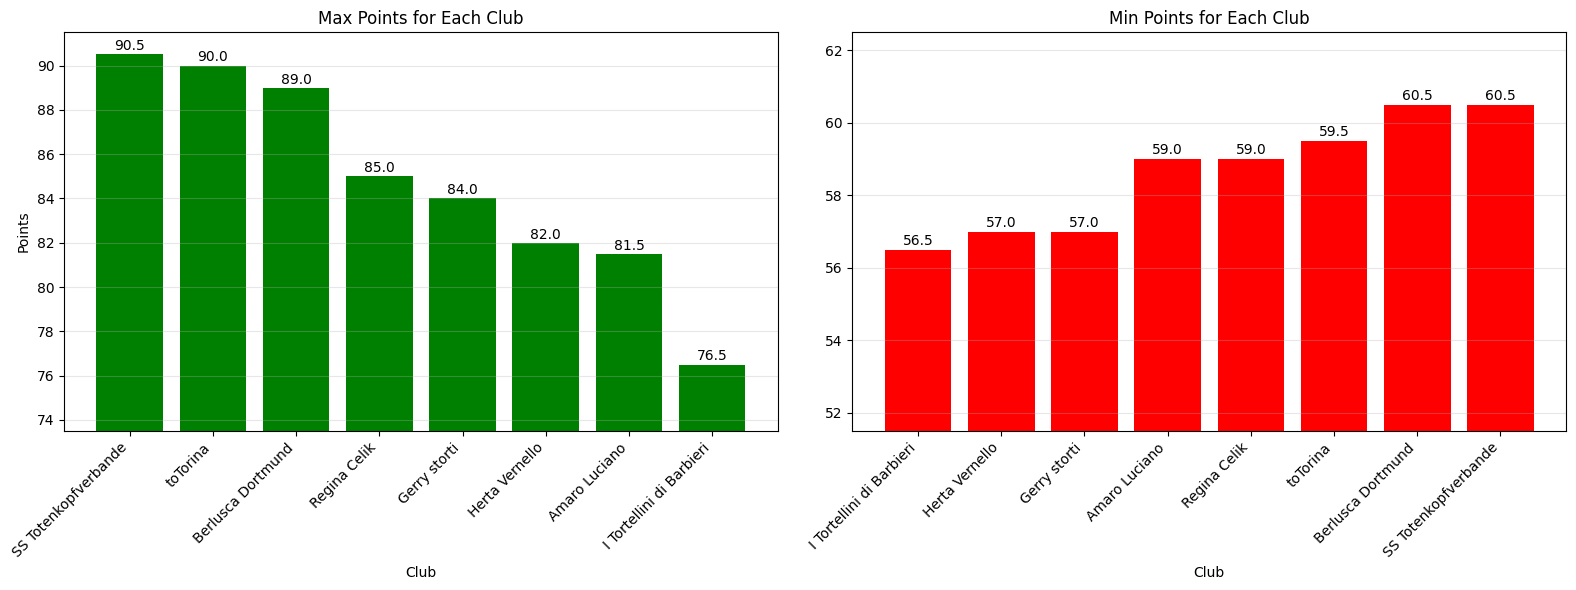

In [64]:
def plot_max_min_points(club_df):
    max_points_per_club = club_df.groupby("Club")["Points"].max()
    min_points_per_club = club_df.groupby("Club")["Points"].min()

    max_points_sorted = max_points_per_club.sort_values(ascending=False)
    min_points_sorted = min_points_per_club.sort_values(ascending=True)

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Max points plot
    axes[0].bar(max_points_sorted.index, max_points_sorted.values, color='green')
    axes[0].set_title("Max Points for Each Club")
    axes[0].set_xlabel("Club")
    axes[0].set_ylabel("Points")
    axes[0].set_ylim(max_points_sorted.min() - 3, max_points_sorted.max() + 1)
    axes[0].grid(axis='y', alpha=0.3)

    axes[0].set_xticks(range(len(max_points_sorted.index)))
    axes[0].set_xticklabels(max_points_sorted.index, rotation=45, ha='right')

    for i, v in enumerate(max_points_sorted):
        axes[0].text(i, v + 0.05, str(v), ha='center', va='bottom', fontsize=10)

    # Min points plot
    axes[1].bar(min_points_sorted.index, min_points_sorted.values, color='red')
    axes[1].set_title("Min Points for Each Club")
    axes[1].set_xlabel("Club")
    axes[1].set_ylim(min_points_sorted.min() - 5, min_points_sorted.max() + 2)
    axes[1].grid(axis='y', alpha=0.3)

    axes[1].set_xticks(range(len(min_points_sorted.index)))
    axes[1].set_xticklabels(min_points_sorted.index, rotation=45, ha='right')

    for i, v in enumerate(min_points_sorted):
        axes[1].text(i, v + 0.05, str(v), ha='center', va='bottom', fontsize=10)

    plt.tight_layout()
    plt.show()

plot_max_min_points(club_df)


## 8 - Points Distribution

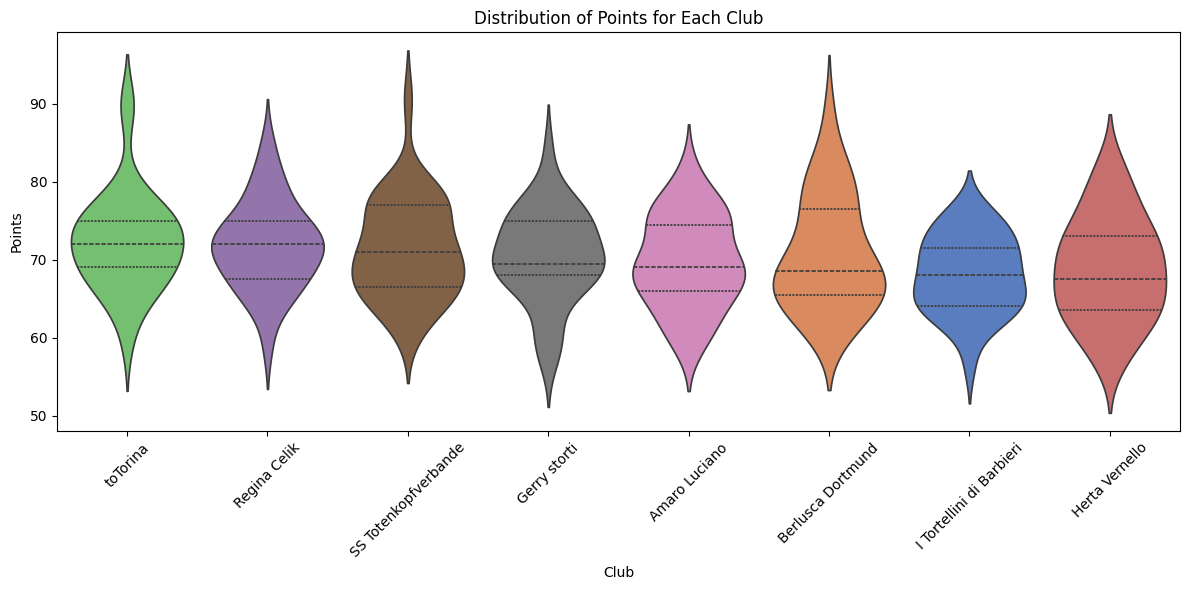

In [75]:
def plot_points_distribution_violin(club_df):
    sorted_clubs = club_df.groupby('Club')['Points'].median().sort_values(ascending=False).index

    plt.figure(figsize=(12, 6))
    sns.violinplot(
        x='Club',
        y='Points',
        data=club_df,
        inner="quart",
        order=sorted_clubs,
        hue='Club',
        palette='muted',
        legend=False
    )

    plt.xlabel("Club")
    plt.ylabel("Points")
    plt.title("Distribution of Points for Each Club")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


plot_points_distribution_violin(club_df)


## 7 - Variance

In [73]:
variance_by_club = np.sqrt(club_df.groupby("Club")["Points"].var())
variance_by_club = variance_by_club.sort_values(ascending=False)
variance_by_club.name = "Variance"
# Convert the Series into a DataFrame and reset the index (this will convert the index into a column)
variance_by_club_df = variance_by_club.reset_index()

# Rename the index column to 'Club'
variance_by_club_df.rename(columns={'index': 'Club'}, inplace=True)

# Merge with the score_board DataFrame on the "Club" column
variance_by_club_df = pd.merge(variance_by_club_df, score_board, on="Club")

variance_by_club_df.head(20)

,Club,Variance,Points,Goals,WDL
0,Berlusca Dortmund,7.254342,2336.0,51.0,57
1,Herta Vernello,6.667247,2270.5,42.0,36
2,toTorina,6.350219,2386.5,60.0,59
3,SS Totenkopfverbande,6.344886,2354.5,56.0,42
4,Gerry storti,5.903862,2324.5,48.0,40
5,Amaro Luciano,5.871130,2301.0,46.0,49
6,Regina Celik,5.600621,2371.0,57.0,53
7,I Tortellini di Barbieri,4.943622,2246.5,34.0,34


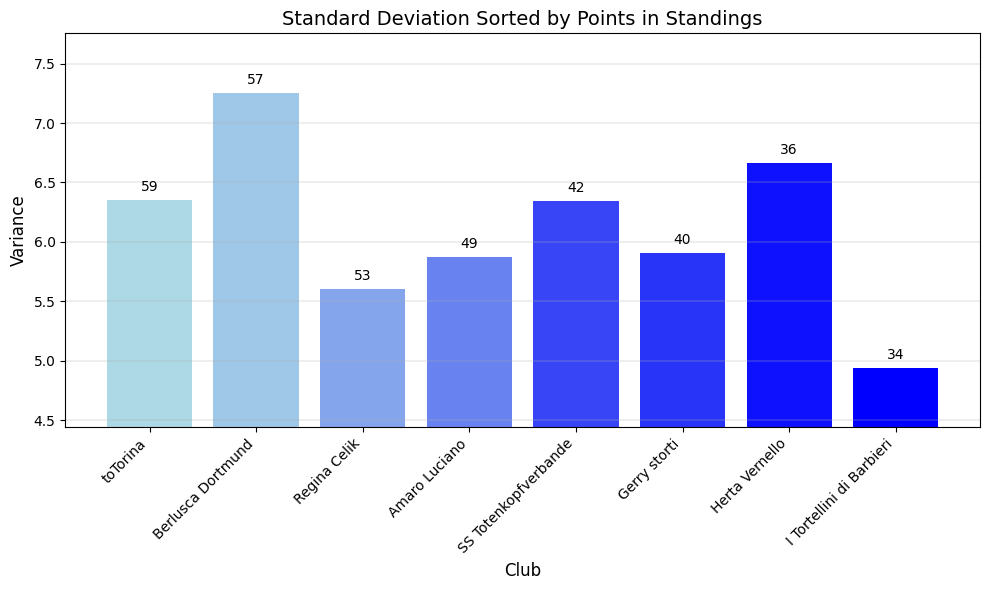

In [148]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def plot_variance_by_wdl(variance_by_club_df):
    # Sort by WDL descending
    sorted_df = variance_by_club_df.sort_values(by='WDL', ascending=False)

    # Normalize WDL for color mapping
    norm = mcolors.Normalize(vmin=sorted_df['WDL'].min(), vmax=sorted_df['WDL'].max())
    cmap = mcolors.LinearSegmentedColormap.from_list("blue_lightblue", ["blue", "lightblue"])

    plt.figure(figsize=(10, 6))
    bars = plt.bar(sorted_df['Club'],
                   sorted_df['Variance'],
                   color=cmap(norm(sorted_df['WDL'])))

    # Add WDL values on top of bars
    for bar, wdl in zip(bars, sorted_df['WDL']):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height + 0.05, f'{wdl}',
                 ha='center', va='bottom', fontsize=10)

    # Set y-limits with a margin
    ymin = sorted_df['Variance'].min() - 0.5
    ymax = sorted_df['Variance'].max() + 0.5
    plt.ylim(ymin, ymax)

    plt.title('Standard Deviation Sorted by Points in Standings', fontsize=14)
    plt.xlabel('Club', fontsize=12)
    plt.ylabel('Variance', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linewidth=0.3)
    plt.tight_layout()
    plt.show()

plot_variance_by_wdl(variance_by_club_df)


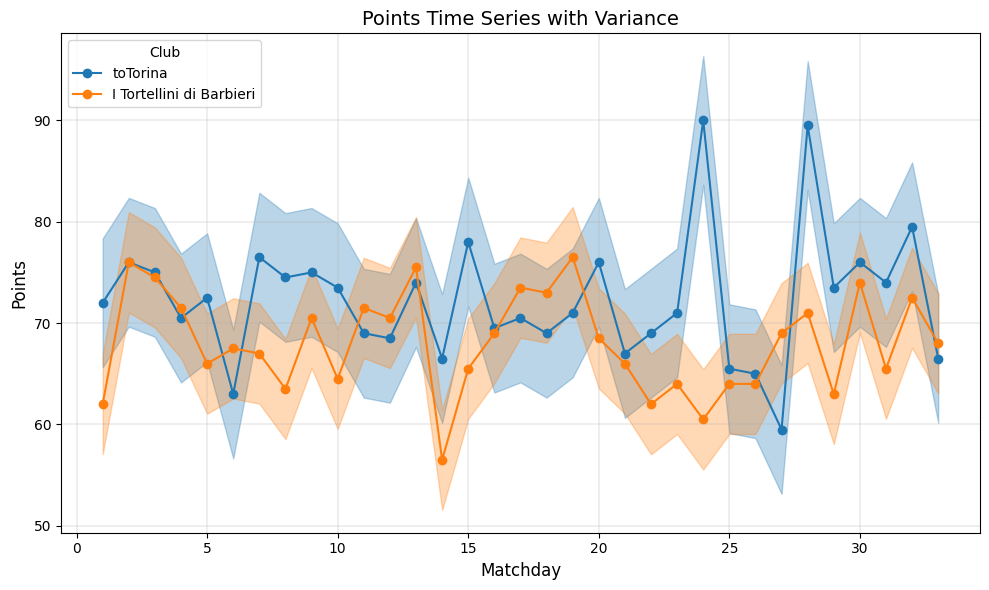

In [88]:
import matplotlib.pyplot as plt
import numpy as np

def plot_points_with_variance(club_df, score_board, clubs_to_plot=None):
    """
    Plot time series of 'Points' with variance shading for selected clubs.
    
    Parameters:
    - club_df: DataFrame containing at least 'Club', 'Matchday', and 'Points' columns.
    - clubs_to_plot: list of club names to plot. If None, uses first and last club in the DataFrame.
    """
    # Get unique club list
    unique_clubs = club_df['Club'].unique()
    
    # Default to first and last club if not specified
    if clubs_to_plot is None:
        clubs_to_plot = score_board.index[[0,-1]].tolist()
    
    # Define default colors
    default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    club_colors = {club: default_colors[i % len(default_colors)] for i, club in enumerate(clubs_to_plot)}
    
    # Create the plot
    plt.figure(figsize=(10, 6))
    
    for club in clubs_to_plot:
        club_data = club_df[club_df["Club"] == club].sort_values(by="Matchday")
        
        mean_points = club_data["Points"].mean()
        variance_points = np.sqrt(club_data["Points"].var())

        # Line plot
        plt.plot(club_data["Matchday"], club_data["Points"],
                 label=club, marker='o', color=club_colors[club])
        
        # Variance shading
        plt.fill_between(club_data["Matchday"],
                         club_data["Points"] - variance_points,
                         club_data["Points"] + variance_points,
                         color=club_colors[club], alpha=0.3)

    # Plot formatting
    plt.title("Points Time Series with Variance", fontsize=14)
    plt.xlabel("Matchday", fontsize=12)
    plt.ylabel("Points", fontsize=12)
    plt.legend(title="Club")
    plt.grid(True, linewidth=0.3)
    plt.tight_layout()
    plt.show()

plot_points_with_variance(club_df, score_board)


## 8 - Win Probability of Each Team

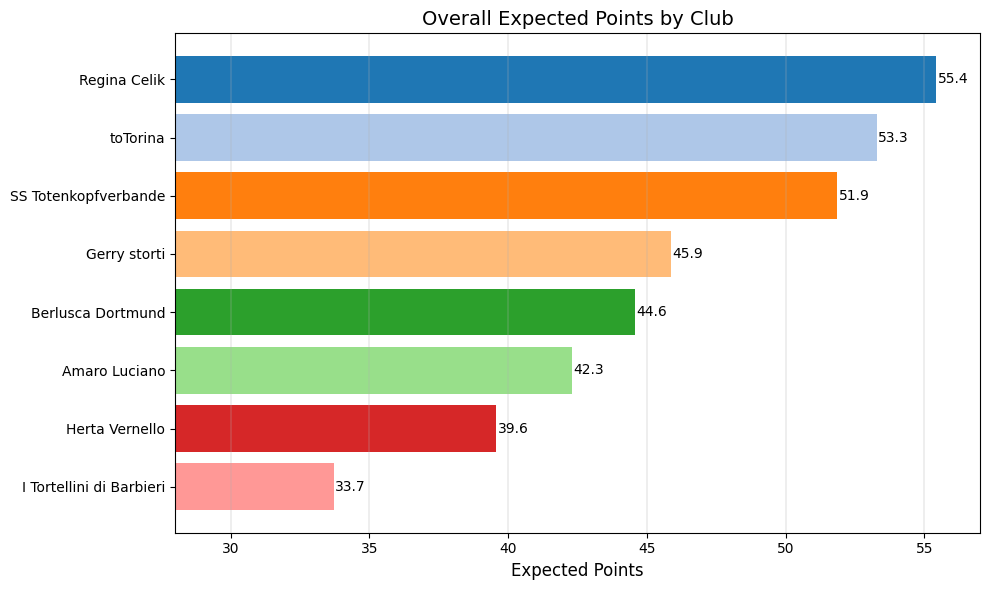

In [121]:
def compute_expected_points(club_df):
    
  clubs_dict = {club: [] for club in club_df['Club'].unique()}

  for match_d in club_df['Matchday'].unique():
    match_d_df = club_df[club_df['Matchday'] == match_d]

    for club in match_d_df['Club'].unique():
      club_goal = match_d_df[match_d_df['Club'] == club]['Goals'].values[0]

      numb_win, numb_lose, numb_drawn = 0, 0, 0

      for other_club in match_d_df['Club'].unique():
        if club != other_club:
          other_club_goal = match_d_df[match_d_df['Club'] == other_club]['Goals'].values[0]

          if club_goal > other_club_goal:
            numb_win += 1
          elif club_goal < other_club_goal:
            numb_lose += 1
          else:
            numb_drawn += 1

      total = numb_win + numb_lose + numb_drawn
      
      if total > 0:
        win_prob = numb_win / total
        drawn_prob = numb_drawn / total

        expected_points = 3 * win_prob + 1 * drawn_prob
        clubs_dict[club].append(expected_points)

  overall_expected_points = {club: sum(points) for club, points in clubs_dict.items()}
  return overall_expected_points


def plot_expected_points(expected_points_dict):
    """
    Plots overall expected points per club as horizontal bars with unique colors per club,
    sorted in descending order.

    Parameters:
    - expected_points_dict: Dictionary of club -> expected points
    """
    # Ordina i club per punti attesi
    sorted_items = sorted(expected_points_dict.items(), key=lambda x: x[1], reverse=True)
    clubs = [item[0] for item in sorted_items]
    points = [item[1] for item in sorted_items]

    # Assegna un colore unico a ciascun club usando una colormap (es. tab20)
    cmap = plt.get_cmap("tab20")
    club_colors = {club: cmap(i % cmap.N) for i, club in enumerate(clubs)}
    bar_colors = [club_colors[club] for club in clubs]

    # Crea il grafico
    plt.figure(figsize=(10, 6))
    bars = plt.barh(clubs, points, color=bar_colors)
    plt.xlabel('Expected Points', fontsize=12)
    plt.title('Overall Expected Points by Club', fontsize=14)
    plt.gca().invert_yaxis()  # Club con più punti in alto
    plt.xlim(int(min(points) - 5), int(max(points) + 1.6))
    plt.grid(axis='x', linewidth=0.3)

    # Aggiungi etichette sui valori
    for bar in bars:
        width = bar.get_width()
        plt.text(width + 0.05, bar.get_y() + bar.get_height() / 2,
                 f'{width:.1f}', va='center', fontsize=10)

    plt.tight_layout()
    plt.show()

expected_points_dict = compute_expected_points(club_df)
plot_expected_points(expected_points_dict)


## 9 - Points Robbed

In [139]:
def compute_points_robbed_from_each_club(df):

  clubs = df['Home'].unique()
  robbed_dict = {club: {} for club in clubs}

  for club in clubs:
    matches = df[(df['Home'] == club) | (df['Away'] == club)]

    for _, row in matches.iterrows():
      if row['Home'] == club:
        club_goals = row['Home_Goals']
        opp_goals = row['Away_Goals']
        opponent = row['Away']
      else:
        club_goals = row['Away_Goals']
        opp_goals = row['Home_Goals']
        opponent = row['Home']

      # Points robbed logic
      if club_goals > opp_goals:
        robbed_points = 0
      elif club_goals < opp_goals:
        robbed_points = 3
      else:
        robbed_points = 2

      if robbed_points > 0:
        if opponent in robbed_dict[club]:
          robbed_dict[club][opponent] += robbed_points
        else:
          robbed_dict[club][opponent] = robbed_points

  return robbed_dict


robbed_data = compute_points_robbed_from_each_club(df)


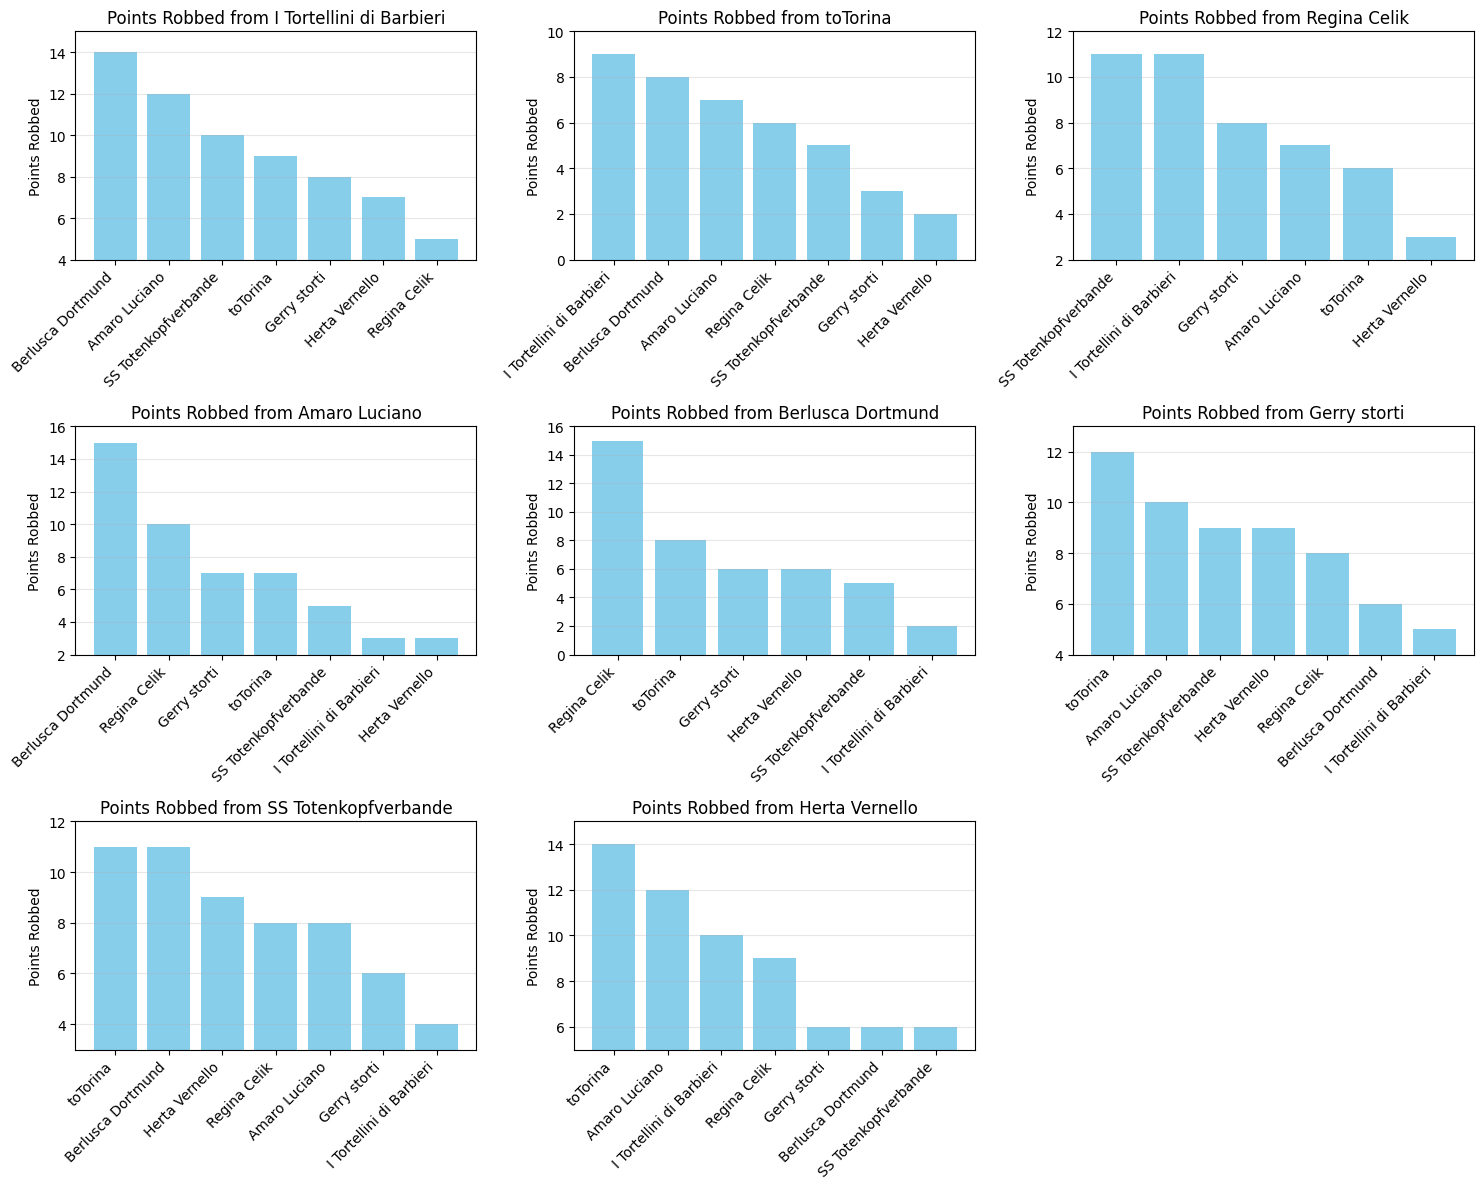

In [147]:
def plot_robbed_points_subplots(robbed_data, cols=3):
    teams = list(robbed_data.keys())
    num_teams = len(teams)
    rows = (num_teams + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))
    axes = axes.flatten()  # flatten in case of multiple rows
    
    for i, team in enumerate(teams):
        ax = axes[i]
        opponents_points = list(robbed_data[team].items())
        # Sort descending by points
        opponents_points.sort(key=lambda x: x[1], reverse=True)
        
        opponents = [op for op, pts in opponents_points]
        points = [pts for op, pts in opponents_points]

        ax.bar(range(len(opponents)), points, color='skyblue')
        ax.set_title(f'Points Robbed from {team}')
        ax.set_ylabel('Points Robbed')

        ax.set_xticks(range(len(opponents)))
        ax.set_xticklabels(opponents, rotation=45, ha='right')

        y_lim_min = min(points) - 1 if min(points) > 2 else 0
        y_lim_max = max(points) + 1 
        ax.set_ylim(y_lim_min, y_lim_max)
        ax.grid(axis='y', alpha=0.3)

        
    # Hide any extra subplots if teams < total subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
        
    plt.tight_layout()
    plt.show()

plot_robbed_points_subplots(robbed_data)
